In [1]:
from EdgeFinderV4 import BoundaryDetector as BD
from PIL import Image
from ImageFrame import Frame
import numpy as np
import matplotlib.pyplot as plt
import timeit


In [1]:
import numba
numba.version_info

version_info(major=0, minor=56, patch=4, short=(0, 56), full=(0, 56, 4), string='0.56.4', tuple=('0', '56', '4'), git_revision=None)

In [121]:
from numba import njit, typed

#@njit
def false_double_side_check(temp_array,a):
    v1 = temp_array[a-1] - temp_array[a-3]
    v2 = temp_array[a-2] - temp_array[a-4]
    if v1[1]==0: v1[1]=1
    if v2[1]==0: v2[1]=1
    product = (v1[0]/v1[1])*(v2[0]/v2[1])
    if product <= 0:
        return np.array([0.0,0.0])
    else:
        angle1 = np.degrees(np.arctan(v1[0]/v1[1]))
        angle2 = np.degrees(np.arctan(v2[0]/v2[1]))
        return np.array([angle1,angle2])
#@njit
def calculate_mid(temp_array,a):
    mp_1 = (temp_array[1] + temp_array[0])/2.0
    mp_2 = (temp_array[3] + temp_array[2])/2.0
    mp_3 = (temp_array[5] + temp_array[4])/2.0
    a_mp_1 = np.degrees(np.arctan((mp_1[0]-640)/mp_1[1]))
    a_mp_2 = np.degrees(np.arctan((mp_2[0]-640)/mp_2[1]))
    a_mp_3 = np.degrees(np.arctan((mp_3[0]-640)/mp_3[1]))
    return np.array([a_mp_1,a_mp_2,a_mp_3])
#@njit
def calculate_side(array):
    array[:,1] = 720 - array[:,1] 
    empty_arrays = np.zeros_like(array)
    v1 = array[3] - array[0]
    v2 = array[2] - array[1]
    product = (v1[0]/v1[1])*(v2[0]/v2[1])
    if product <= 0:     #Check here : Check product of the slops here and up there
        return empty_arrays
    else:
        empty_arrays[0][0] = np.degrees(np.arctan(v1[0]/v1[1]))
        empty_arrays[0][1] = np.degrees(np.arctan(v2[0]/v2[1]))
        return empty_arrays

#@njit
def single_side_check(temp_arrays):
    right_side = temp_arrays[::2]
    left_side = temp_arrays[1::2]
    a = np.count_nonzero(right_side[:,0])
    b = np.count_nonzero(left_side[:,0])
    if a >= 4:    
        right_side_nZero = np.zeros((a,2))
        i=0
        for n in right_side:
            if not n[0]==0:
                right_side_nZero[i] = n
                i = i + 1
        angle = calculate_side(right_side_nZero)
        return angle,right_side_nZero
    elif b >= 4:
        left_side_nZero = np.zeros((b,2))
        i=0
        for n in left_side:
            if not n[0]==0:
                left_side_nZero[i] = n
                i = i + 1
        angle = calculate_side(left_side_nZero)
        return angle,left_side_nZero
    else:
        empty_array = np.zeros_like(right_side)
        return empty_array,empty_array

#@njit
def get_angle(boundary_points):
    lenght_of_array = len(boundary_points[:,0])
    temp_array = np.zeros_like(boundary_points)
    a = 0
    for n in range(0,lenght_of_array,2):
        if np.mean(boundary_points[n]) and np.mean(boundary_points[n+1]): #check for pairs
            temp_array[a]=boundary_points[n]
            temp_array[a+1] = boundary_points[n+1]
            a = a+2
        if a >= 6:
            #check before calculating mid-points
            temp_array[:a,1] = 720 - temp_array[:a,1] 
            check =  false_double_side_check(temp_array,a)
            if check[0] : 
                return 1,check,temp_array# return the angle and points of the checks
            return 2,calculate_mid(temp_array,a),temp_array
    cp_boundary_points = np.copy(boundary_points)
    a,b= single_side_check(cp_boundary_points)
    if a[0][0]:
        return 3,a[0],b
    else:
        return 4,a[0],b
    


In [101]:
#FIR filtering algorithm
#The algorithm start by definding some value

FIR_filter_lenght = 4
FIR_filter_impulse = np.full((FIR_filter_lenght),1/FIR_filter_lenght)
FIR_filter_buf = np.zeros(FIR_filter_lenght,dtype=np.int64)
FIR_filter_bufindex = 0

@njit
def FIR_update(data):
    
    FIR_filter_buf[FIR_filter_bufindex] = data
    FIR_filter_bufindex += 1
    if FIR_filter_bufindex == FIR_filter_lenght:
        FIR_filter_bufindex = 0
    some_index = FIR_filter_bufindex
    out = 0
    for n in range(FIR_filter_lenght):
        if some_index>0:
            some_index -= 1
        else:
            some_index = FIR_filter_lenght-1
        out += FIR_filter_impulse[n] * FIR_filter_buf[some_index]
    return [out]


In [103]:
from numba.experimental import jitclass
from numba import uint8, float32
spec = [
    ('lenght', uint8),               # a simple scalar field
    ('buf', float32[:]),
    ('bufindex', uint8),          # an array field
    ('impulse', float32[:]),          # an array field
    ('out', float32),          # an array field
]
@jitclass(spec)
class FIR_filter(object):

    def __init__(self,lenght):
        self.lenght = lenght
        self.buf = np.zeros(lenght,dtype=np.float32)
        self.bufindex = 0
        self.out = 0
        self.impulse = np.full((lenght),1/lenght,dtype=np.float32)
    
    def updata(self,data):
        self.buf[self.bufindex] = data
        self.bufindex +=1
        if self.bufindex== self.lenght:
            self.bufindex=0
        sum_index = self.bufindex
        self.out=0
        for n in range(self.lenght):
            if sum_index>0:
                sum_index -=1
            else:
                sum_index = self.lenght-1
            self.out += self.impulse[n] * self.buf[sum_index]
        return self.out

load CVS file successfully
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188


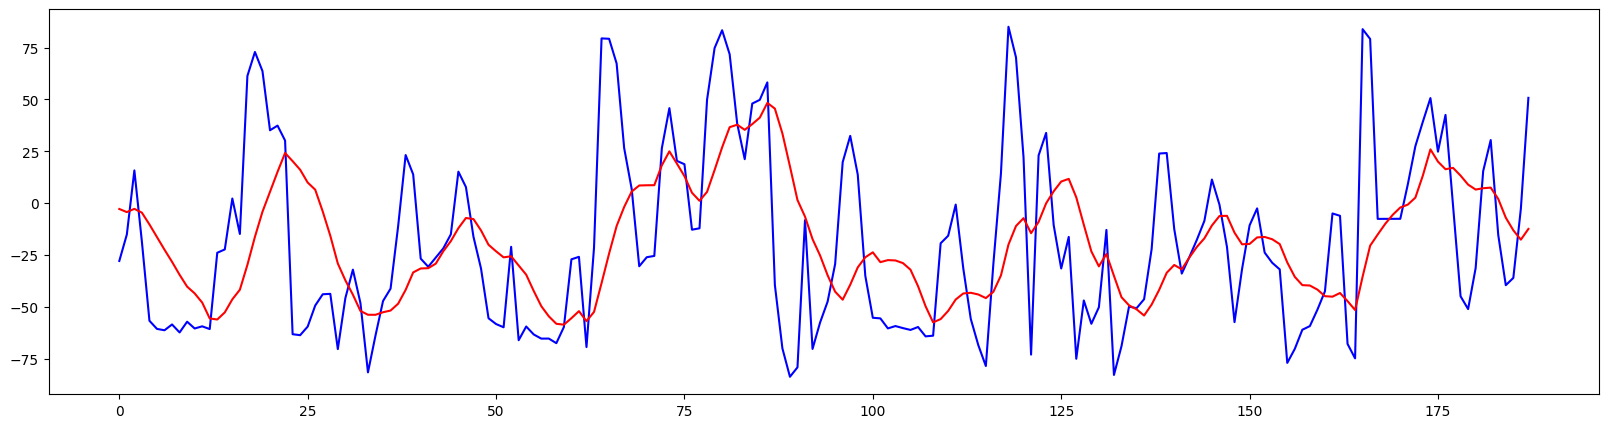

In [126]:
#creating frame and importing image
frame1 = Frame(1280,720,5,720/2,720)
global tp_by 
tp_by = 720/2
global bm_by
bm_by = 720
#fig, ax = plt.subplots(9,4,figsize=(19,27))
sample_number = 188
steering_data = np.zeros([sample_number])
steeringFiltered_data = np.zeros([sample_number])
myFilter = FIR_filter(10)

for n in range(1,sample_number+1,1):
    
    img = np.array(Image.open("TestingImage/Image"+str(n)+".jpg"))
    #applying the masks to the image
    kernal = np.array([-1,-1,-1,0,1,1,1])
    #Using EdgeDetection
    BP = BD(img[:,:,0],kernal,frame1,60)

    P = BP.boundary
    
    print(n)
    A = get_angle(P)    
    steering_data[n-1] = np.mean(A[1])
    steeringFiltered_data[n-1] = myFilter.updata(np.mean(A[1]))

    #ax[int((n-1)/4),(n-1)-4*int((n-1)/4)].imshow(img)
    #for key in frame1.fline.keys():
    #    ax[int((n-1)/4),(n-1)-4*int((n-1)/4)].plot(frame1.fline[key][:,0],frame1.fline[key][:,1],'k,')
    #ax[int((n-1)/4),(n-1)-4*int((n-1)/4)].set_title("Image {num}".format(num=n+32))
    #ax[int((n-1)/4),(n-1)-4*int((n-1)/4)].plot(BP.boundary[:,0],BP.boundary[:,1],"ro")
    #ax[int((n-1)/4),(n-1)-4*int((n-1)/4)].set_xticks([]), ax[int((n-1)/4),(n-1)-4*int((n-1)/4)].set_yticks([])

    #BP.ploting_onImage(img,str(n)+' case '+str(A[0]))
    #plt.plot(A[2][:,0], 720-A[2][:,1], 'b.')
    #plt.plot([1280/2,1280/2+200*np.sin(np.deg2rad(A[1][0]))],[720-0.0,720-200*np.cos(np.deg2rad(A[1][0]))],'b-')
    #print(np.mean(A[1]))        
    # 
    #plt.show()
plt.figure(figsize=(20,5))
plt.plot(range(len(steering_data)),steering_data,'b')
plt.plot(range(len(steeringFiltered_data)),steeringFiltered_data,'r')


load CVS file successfully


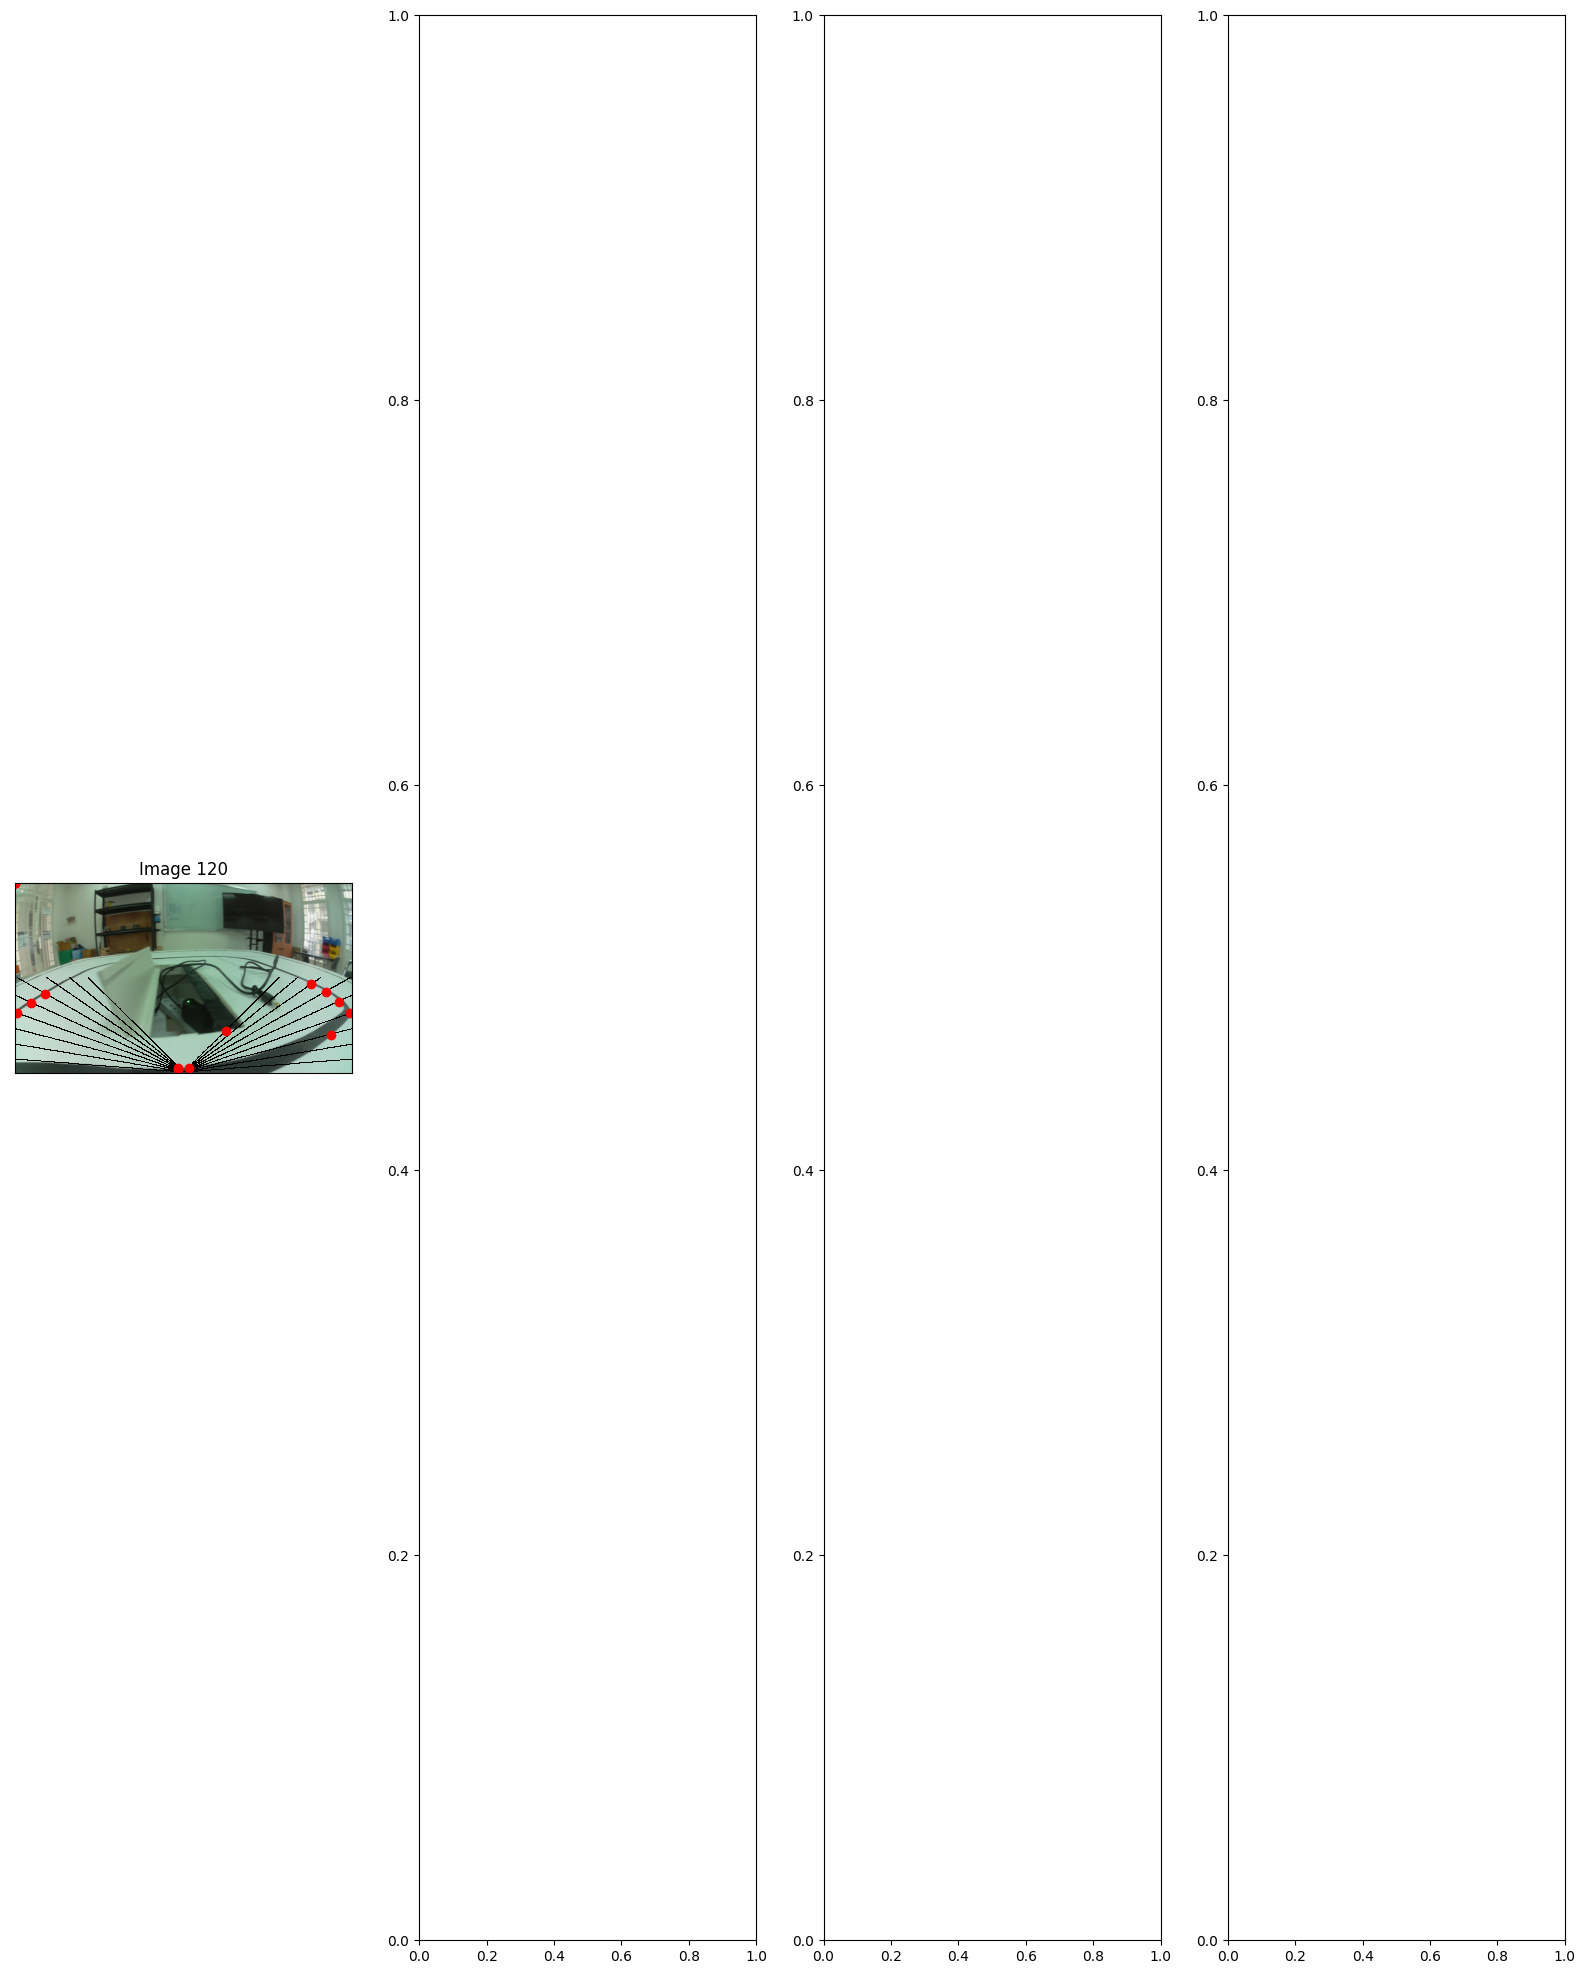

In [124]:
#creating frame and importing image
frame1 = Frame(1280,720,5,720/2,720)
fig, ax = plt.subplots(1,4,figsize=(20,25))
imgs = [120]
for i,n in enumerate(imgs):
    
    img = np.array(Image.open("TestingImage/Image"+str(n)+".jpg"))
    #applying the masks to the image
    kernal = np.array([-1,-1,0,1,1])
    #Using EdgeDetection
    BP = BD(img[:,:,0],kernal,frame1,90)

    P = BP.boundary
    
    #print(P)
    #A = get_angle(P)    
    ax[i].imshow(img)
    for key in frame1.fline.keys():
        ax[i].plot(frame1.fline[key][:,0],frame1.fline[key][:,1],'k,')
    ax[i].set_title("Image {num}".format(num=n))
    ax[i].plot(BP.boundary[:,0],BP.boundary[:,1],"ro")
    ax[i].set_xticks([]), ax[i].set_yticks([])

    #BP.ploting_onImage(img,str(n)+' case '+str(A[0]))
    #plt.plot(A[2][:,0], 720-A[2][:,1], 'b.')
    #plt.plot([1280/2,1280/2+200*np.sin(np.deg2rad(A[1][0]))],[720-0.0,720-200*np.cos(np.deg2rad(A[1][0]))],'b-')
    #print(A)        
    # 
plt.show()

In [ ]:
plt.axis((0,1280,0,720))
plt.plot(A[2][:,0], A[2][:,1], 'ko')
plt.plot([1280/2,1280/2+100*np.sin(np.deg2rad(A[1][0]))],[0.0,100*np.cos(np.deg2rad(A[1][0]))],'k-')

In [ ]:
frame1 = Frame(1280,720,10)
img = np.array(Image.open("TestingImage/Image"+str(1)+".jpg"))

fig,ax = plt.subplots(1,2,figsize=(19,5))
ax[0].axis([0,1280,720,0])
ax[0].set_title('Lines and Mask',size = 15)
ax[0].set_xlabel('(a)',size = 15)
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(img)
ax[1].set_title('Source Image',size = 15)
ax[1].set_xlabel('(b)',size = 15)
ax[1].set_xticks([])
ax[1].set_yticks([])
for key in frame1.fline.keys():
    ax[0].plot(frame1.fline[key][:,0],frame1.fline[key][:,1],'r,')
    ax[1].plot(frame1.fline[key][:,0],frame1.fline[key][:,1],'r,')
plt.show

In [ ]:
get_angle(P)

In [ ]:
for i,n in enumerate(P[::2]):
    print(f'i {i} n{n}')

In [ ]:
a = P[::2]
print(f'original {a}')
a[:3,1]=720 - a[:3,1]
print(f'new {a}')
print(f'P {P}')

In [ ]:
a = np.zeros((int(1280/2),2))
ll = np.array([[int(1280/2)-1,720-1]])  #init the first point of the left line ex same as above
a[0] = [int(1280/2)-1,720-1]

In [ ]:
a = np.array([[1,2],[0,0],[1,1],[1,1]])
right = a[::2]
left = a[::2][~np.all(a[::2]==0,axis=1)]

In [ ]:
left